In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
#@title Imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>

In [3]:
# @title Data structures

import graphviz
import copy
from random import random


class MinCut:
    """A representation of an event in a probability tree."""

    def __init__(self, root, t=frozenset(), f=frozenset()):
        self._root = root
        self.t = t
        self.f = f

    def __str__(self):

        true_elements = ", ".join([str(id) for id in sorted(self.t)])
        false_elements = ", ".join([str(id) for id in sorted(self.f)])
        return "{true: {" + true_elements + "}, false: {" + false_elements + "}}"

    def __reptr__(self):
        return self.__str__()

    # Proposition
    def prop(root, statement):
        cond_lst = Node._parse_statements(statement)

        # Complain if more than one statement.
        if len(cond_lst) != 1:
            raise Exception("'prop' takes one and only one statement.")
            return None

        # Remove list envelope.
        cond = cond_lst[0]

        # Recurse.
        return MinCut._prop(root, root, cond)

    def _prop(root, node, cond):
        # Take var and val of condition.
        condvar, condval = cond

        # Search for variable.
        for var, val in node.assign:
            if condvar == var:
                if condval == val:
                    return MinCut(root, frozenset([node.id]), frozenset())
                else:
                    return MinCut(root, frozenset(), frozenset([node.id]))

        # If we reach a leaf node and the variable isn't resolved,
        # raise an exception.
        if not node.children:
            msg = (
                "Node "
                + str(node.id)
                + ": "
                + 'min-cut for condition "'
                + condvar
                + " = "
                + condval
                + '" is undefined.'
            )
            raise Exception(msg)

        # Variable not found, recurse.
        t_set = frozenset()
        f_set = frozenset()
        for child in node.children:
            _, subnode = child
            subcut = MinCut._prop(root, subnode, cond)
            t_set = t_set.union(subcut.t)
            f_set = f_set.union(subcut.f)

        # Consolidate into node if children are either only true or false nodes.
        cut = MinCut(root, t_set, f_set)
        if not cut.f:
            cut.t = frozenset([node.id])
        elif not cut.t:
            cut.f = frozenset([node.id])

        return cut

    # Negation
    def neg(self):
        return MinCut(self._root, t=self.f, f=self.t)

    def __invert__(self):
        return self.neg()

    # Conjunction
    def conj(root, cut1, cut2):
        return MinCut._conj(root, root, cut1, cut2, False, False)

    def _conj(root, node, cut1, cut2, end1=False, end2=False):
        # Base case.
        if (node.id in cut1.f) or (node.id in cut2.f):
            return MinCut(root, frozenset(), frozenset([node.id]))
        if node.id in cut1.t:
            end1 = True
        if node.id in cut2.t:
            end2 = True
        if end1 and end2:
            return MinCut(root, frozenset([node.id]), frozenset())

        # Recurse.
        t_set = frozenset()
        f_set = frozenset()
        for _, subnode in node.children:
            subcut = MinCut._conj(root, subnode, cut1, cut2, end1, end2)
            t_set = t_set.union(subcut.t)
            f_set = f_set.union(subcut.f)

        # Consolidate into node if children are either only true or false nodes.
        cut = MinCut(root, t_set, f_set)
        if not cut.f:
            cut.t = frozenset([node.id])
        elif not cut.t:
            cut.f = frozenset([node.id])
        return cut

    def __and__(self, operand):
        return MinCut.conj(self._root, self, operand)

    # Disjunction
    def disj(root, cut1, cut2):
        return MinCut.neg(MinCut.conj(root, MinCut.neg(cut1), MinCut.neg(cut2)))

    def __or__(self, operand):
        return MinCut.disj(self._root, self, operand)

    # Causal dependence
    def precedes(root, cut_c, cut_e):
        return MinCut._precedes(root, root, cut_c, cut_e, False)

    def _precedes(root, node, cut_c, cut_e, found_c):
        # Base case.
        if not found_c:
            if node.id in cut_e.t or node.id in cut_e.f or node.id in cut_c.f:
                return MinCut(root, frozenset(), frozenset([node.id]))
            if node.id in cut_c.t:
                found_c = True
        if found_c:
            if node.id in cut_e.t:
                return MinCut(root, frozenset([node.id]), frozenset())
            if node.id in cut_e.f:
                return MinCut(root, frozenset(), frozenset([node.id]))

        # Recursion.
        t_set = frozenset()
        f_set = frozenset()
        for _, subnode in node.children:
            subcut = MinCut._precedes(root, subnode, cut_c, cut_e, found_c)
            t_set = t_set.union(subcut.t)
            f_set = f_set.union(subcut.f)

        # Consolidate into node if children are either only true or false nodes.
        cut = MinCut(root, t_set, f_set)
        if not cut.f:
            cut.t = frozenset([node.id])
        elif not cut.t:
            cut.f = frozenset([node.id])
        return cut

    def __lt__(self, operand):
        return MinCut.precedes(self._root, self, operand)


class Critical:
    """A representation of the critical set associated to an event."""

    # Constructor
    def __init__(self, s=frozenset()):
        self.s = s

    def __str__(self):
        elements = ", ".join([str(id) for id in sorted(self.s)])
        return "{" + elements + "}"

    def __reptr__(self):
        return self.__str__()

    def critical(root, cut):
        _, crit = Critical._critical(root, cut)
        return crit

    def _critical(node, cut):
        # Base case.
        if node.id in cut.t:
            return (False, Critical(frozenset()))
        if node.id in cut.f:
            return (True, Critical(frozenset()))
        # Recurse.
        s = frozenset()
        for _, subnode in node.children:
            incut, subcrit = Critical._critical(subnode, cut)
            if incut:
                s = s.union(frozenset([node.id]))
            else:
                s = s.union(subcrit.s)

        return (False, Critical(s))


class Node:
    """A node in probability tree."""

    # Constructor.
    def __init__(self, uid, statements, children=None, expectation=0):
        # Automatically assigned ID.
        self.id = uid

        # Assignments.
        if isinstance(statements, str):
            self.assign = Node._parse_statements(statements)
        else:
            self.assign = statements

        # Children.
        if children is None:
            self.children = []
        else:
            self.children = children

    # Parse statements.
    def _parse_statements(statements):
        statement_list = statements.split(",")
        pair_list = [x.split("=") for x in statement_list]
        assign = [(var.strip(), val.strip()) for var, val in pair_list]
        return assign

    # Sample.
    def sample(self):
        return self._sample(dict())

    def _sample(self, smp):
        # Add new assignments.
        newsmp = {var: val for var, val in self.assign}
        smp = dict(smp, **newsmp)

        # Base case.
        if not self.children:
            return smp

        # Recurse.
        rnum = random()
        for child in self.children:
            subprob, subnode = child
            rnum -= subprob
            if rnum <= 0:
                return subnode._sample(smp)

        # Something went wrong: probabilities aren't normalized.
        msg = (
            "Node "
            + str(self.id)
            + ": "
            + "probabilities of transitions do not add up to one."
        )
        raise Exception(msg)

    # Insert.
    def insert(self, prob, node):
        self.children.append((prob, node))

    # Compute probability of cut.
    def prob(self, cut):
        return self._prob(cut, 1.0)

    def _prob(self, cut, prob):
        # Base case.
        if self.id in cut.t:
            return prob
        if self.id in cut.f:
            return 0.0

        # Recurse.
        probsum = 0.0
        for child in self.children:
            subprob, subnode = child
            resprob = subnode._prob(cut, prob * subprob)
            probsum += resprob

        return probsum

    # Return a dictionary with all the random variables and their values.
    def rvs(self):
        sts = dict()
        return self._rvs(sts)

    def _rvs(self, sts):
        for var, val in self.assign:
            if not (var in sts):
                sts[var] = list()
            if not (val in sts[var]):
                sts[var].append(val)

        for _, subnode in self.children:
            sts = subnode._rvs(sts)

        return sts

    # Auxiliary function for computing the list of children.
    def _normalize_children(children, probsum, logsum):
        newchildren = None
        if probsum > 0.0:
            newchildren = [
                (subprob / probsum, subnode) for _, subprob, subnode in children
            ]
        else:
            newchildren = [
                (sublog / logsum, subnode) for sublog, _, subnode in children
            ]
        return newchildren

    # Auxiliary function for getting expectation.
    def get_expectation(self):
        return self.expectation

    # Expectation w.r.t. target
    def ep(self, target):
        expec_dict = {}
        root = copy.deepcopy(self)
        root._ep(target, expec_dict)
        return expec_dict

    def _ep(self, target, expec_dict):
        # Base case.
        if self.children == []:
            if target in self.assign:
                print(f"yes: {self.assign}")
                new_assign = self.assign.append(("Expec", "1"))
                self.assign = new_assign
                self.expectation = 1
                expec_dict[self.id] = self.expectation
                return None
            else:
                print(f"no: {self.assign}")
                new_assign = self.assign.append(("Expec", "0"))
                self.assign = new_assign
                self.expectation = 0
                expec_dict[self.id] = self.expectation
                return None

        expec_sum = 0.0

        for subprob, subnode in self.children:
            print(subprob)
            subnode._ep(target, expec_dict)
            expec_sum += subprob * subnode.get_expectation()

        print(f"expec sum is: {expec_sum}")
        self.expectation = expec_sum
        self.assign.append(("Expec", str(expec_sum)))
        print(self.assign)
        expec_dict[self.id] = self.expectation
        return None

    def gpn(self, tolerance, expect_dict, target):
        p_nodes = []
        p_nodes = self._gpn(tolerance, expec_dict, target, p_nodes)
        return p_nodes

    def _gpn(self, tolerance, expec_dict, target, p_nodes):
        if self.children == []:
            return p_nodes
        for _, subnode in self.children:
            if (expec_dict[subnode.id] - expec_dict[self.id]) >= tolerance:
                prevented_trace = self._gpt(subnode.id, expec_dict, target, [self.id])
                p_nodes.append((subnode.id, prevented_trace))
            p_nodes = subnode._gpn(tolerance, expec_dict, target, p_nodes)
        return p_nodes

    def _gpt(self, sig_node, expec_dict, target, p_trace):
        if self.children == []:
            return p_trace
        (max_prob, max_node) = (0, 0)
        for subprob, subnode in self.children:
            if subnode.id != sig_node and subprob > max_prob:
                (max_prob, max_node) = (subprob, subnode)
        p_trace.append(max_node.id)
        p_trace = max_node._gpt(sig_node, expec_dict, target, p_trace)
        return p_trace

    # Conditioning
    def see(self, cut):
        root = copy.deepcopy(self)
        root._see(cut, 1.0)
        return root

    def _see(self, cut, prob):
        # Base case.
        if self.id in cut.t:
            newnode = Node(self.id, self.assign)
            return (1.0, prob)
        if self.id in cut.f:
            newnode = Node(self.id, self.assign)
            return (0.0, 0.0)

        # Recurse.
        newchildren = []
        probsum = 0.0
        logsum = 0.0
        for subprob, subnode in self.children:
            reslog, resprob = subnode._see(cut, prob * subprob)

            newchildren.append((reslog, resprob, subnode))
            logsum += reslog
            probsum += resprob

        # Normalize.
        self.children = Node._normalize_children(newchildren, probsum, logsum)

        return (1.0, probsum)

    # Causal intervention
    def do(self, cut):
        root = copy.deepcopy(self)
        root._do(cut)
        return root

    def _do(self, cut):
        # Base case.
        if self.id in cut.t:
            return True
        if self.id in cut.f:
            return False

        # Recurse.
        newchildren = []
        probsum = 0.0
        logsum = 0.0
        for subprob, subnode in self.children:
            resdo = subnode._do(cut)

            if resdo:
                newchildren.append((1.0, subprob, subnode))
                probsum += subprob
                logsum += 1.0
            else:
                newchildren.append((0.0, 0.0, subnode))

        # Normalize.
        self.children = Node._normalize_children(newchildren, probsum, logsum)

        return (1.0, probsum)

    # Counterfactual/subjunctive conditional
    def cf(self, root_prem, cut_subj):
        root_subj = self.do(cut_subj)
        root_subj._cf(root_prem, cut_subj)
        return root_subj

    def _cf(self, prem, cut):
        # Base case.
        if self.id in cut.t:
            return True
        if self.id in cut.f:
            return False

        # Recurse.
        critical = False

        for child, child_prem in zip(self.children, prem.children):
            (_, subnode) = child
            (_, subnode_prem) = child_prem
            in_do = subnode._cf(subnode_prem, cut)
            if not in_do:
                critical = True
                continue

        # Pick children if node is critical.
        if not critical:
            self.children = [
                (subprob, subnode)
                for (_, subnode), (subprob, _) in zip(self.children, prem.children)
            ]

        return True

    # Show probability tree.
    def show(self, show_id=False, show_prob=False, cut=None, crit=None):
        # Initialize Digraph.
        graph_attr = {
            "bgcolor": "White",
            "rankdir": "LR",
            "nodesep": "0.1",
            "ranksep": "0.3",
            "sep": "0",
        }
        node_attr = {
            "style": "rounded",
            "shape": "box",
            "height": "0.1",
            "width": "0.5",
            "fontsize": "10",
            "margin": "0.1, 0.02",
        }
        edge_attr = {"fontsize": "10"}
        g = graphviz.Digraph(
            "g",
            format="svg",
            graph_attr=graph_attr,
            node_attr=node_attr,
            edge_attr=edge_attr,
        )

        # Recursion.
        return self._show(
            g, 1.0, show_id=show_id, show_prob=show_prob, cut=cut, crit=crit
        )

    def _show(self, g, prob, show_id=False, show_prob=False, cut=None, crit=None):
        # Create label.
        print(self.assign)
        labels = [name + " = " + value for name, value in self.assign]
        node_label = "\n".join(labels)
        if show_id:
            node_label = str(self.id) + "\n" + node_label
        if show_prob:
            node_label = node_label + "\np = " + "{0:.3g}".format(prob)

        # Decorate node.
        attr = {"style": "filled, rounded", "fillcolor": "WhiteSmoke"}
        if not (cut is None):
            if self.id in cut.t:
                attr = {"style": "filled, rounded", "fillcolor": "AquaMarine"}
            elif self.id in cut.f:
                attr = {"style": "filled, rounded", "fillcolor": "LightCoral"}
        if not (crit is None):
            if self.id in crit.s:
                attr = {"style": "filled, rounded", "fillcolor": "Plum"}
        g.node(str(self.id), label=node_label, **attr)

        # Recurse.
        for child in self.children:
            subprob, subnode = child
            subnode._show(
                g,
                prob * subprob,
                show_id=show_id,
                show_prob=show_prob,
                cut=cut,
                crit=crit,
            )
            g.edge(str(self.id), str(subnode.id), label="{0:.3g}".format(subprob))

        return g

    def find(self, uid):
        if self.id == uid:
            return self

        for child in self.children:
            subprob, subnode = child
            found_node = subnode.find(uid)
            if found_node is not None:
                return found_node

        return None


class PTree:
    """A probability tree."""

    def __init__(self):
        """Create a probability tree."""
        self._root = None
        self._count = 0

    def root(self, statements, children=None):
        """Sets the root node.

        Parameters
        ----------
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the root node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs. These are the root
            node's children and their transition probabilities.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
        self._count += 1
        self._root = Node(self._count, statements, children)
        return self._root

    def child(self, prob, statements, children=None):
        """Create a child node and its transition probability.

        Parameters
        ----------
        prob : float
            The probability of the transition
        statements : str
            A string containing a comma-separated list of statements of
            the form "var = val", such as "X=1, Y=0". These are the
            values resolved by the child node.
        children : list((float, Node)), (default: None)
            A list of (probability, child node) pairs to be set as the
            children of the node.

        Returns
        -------
        Node
            the created node.
        """
        self._count += 1
        return (prob, Node(self._count, statements, children))

    def get_root(self):
        """Return the root node.

        Returns
        -------
        Node
            the root node of the probability tree.
        """
        return self._root

    def show(self, show_id=False, show_prob=False, cut=None, crit=None):
        """Returns a graph of the probability tree.

        Parameters
        ----------
        show_id: Bool (default: False)
            If true, display the unique id's.
        show_prob : Bool (default: False)
            If true, display the node probabilities.
        cut : MinCut (default: None)
            If a MinCut is given, then display it.
        crit : Critical (default: None)
            If a Critical set is given, then show it.

        Returns
        -------
        Node
            the created node.
        """
        return self._root.show(show_id=show_id, show_prob=show_prob, cut=cut, crit=crit)

    def rvs(self):
        """Return a dictionary with all the random variables and their values.

        Returns
        -------
        dict(str: list)
            A dictionary with all the random variables pointing at lists
            containing their possible values.
        """
        return self._root.rvs()

    def rv(self, var):
        """Return a probability distribution for a given random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        list((float, str))
            A list with pairs (prob, val), where prob and val are the
            probability
            and the value of the random variable.
        """
        return [
            (self.prob(self.prop(var + " = " + val)), val) for val in self.rvs()[var]
        ]

    def expect(self, var):
        """Return the expected value of a random variable.

        Parameters
        ----------
        var: str
            A string containing the name of the random variable.

        Returns
        -------
        float
            The expected value of the random variable.
        """
        e = 0.0
        for prob, val in self.rv(var):
            e += prob * float(val)
        return e

    def find(self, uid):
        """Return a node with given unique identifier.

        Parameters
        ----------
        uid: int
            Identifier of the node to be returned.

        Returns
        -------
        Node or None
            Returns the node if found, otherwise None.
        """
        return self._root.find(uid)

    def prop(self, statement):
        """Returns min-cut of a statement.

        Parameters
        ----------
        statement: str
            A single statement of the form "var = val", such as "X = 1".

        Returns
        -------
        MinCut
            the min-cut of the event corresponding to the statement.
        """
        return MinCut.prop(self._root, statement)

    def critical(self, cut):
        """Returns critical set of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cuts.

        Returns
        -------
        Critical
            the critical set for the min-cut.
        """
        return Critical.critical(self._root, cut)

    def sample(self):
        """Sample a realization.

        Returns
        -------
        dict((str:str))
            A dictionary of bound random variables such as

                { 'X': '1', 'Y': '0' }.
        """
        return self._root.sample()

    def prob(self, cut):
        """Compute probability of a min-cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            The probability of the event of the min-cut.
        """
        return self._root.prob(cut)

    def see(self, cut):
        """Return a probability tree conditioned on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        PTree
            A new probability tree.
        """
        newptree = PTree()
        newptree._root = self._root.see(cut)
        return newptree

    def do(self, cut):
        """Intervene on a cut.

        Parameters
        ----------
        cut: MinCut
            A min-cut for an event.

        Returns
        -------
        float
            A new probability tree.
        """
        newptree = PTree()
        newptree._root = self._root.do(cut)
        return newptree

    def cf(self, tree_prem, cut_subj):
        """Return a subjunctive conditional tree.

        Parameters
        ----------
        tree_prem: PTree
            A probality tree representing the premises for the subjunctive
            evaluation.
            This probability tree must have been obtained through operations on
            the
            base probability tree.
        cut_do: MinCut
            A min-cut for an event. This min-cut is the subjunctive condition of
            the
            counterfactual.

        Returns
        -------
        float
            A new probability tree.
        """
        newptree = PTree()
        newptree._root = self._root.cf(tree_prem._root, cut_subj)
        return newptree

    def expectation_tree(self, target):
        """Return a subjunctive conditional tree."""
        expec_dict = self._root.ep(target)
        return expec_dict

    def get_prevention_nodes(self, tolerance, expec_dict, target):
        """Return a subjunctive conditional tree."""
        prevention_nodes = self._root.gpn(tolerance, expec_dict, target)
        return prevention_nodes

    def fromFunc(func, root_statement=None):
        """Build a probability tree from a factory function.

        Building probability trees can be difficult, especially when we have
        to manually specify all its nodes. To simplify this, `fromFunc` allows
        building a probability tree using a factory function. A factory
        function is a function that:

        - receives a dictionary of bound random variables, such as

            { 'X': '1', 'Y': '0' }

        - and returns either `None` if a leaf has been reached, or a list
          of transitions and their statements, such as

            [(0.3, 'Z = 0'), (0.2, 'Z = 1'), (0.5, 'Z = 2')].

        Such a factory function contains all the necessary information for
        building a probability tree.

        The advantage of using a factory function is that we can exploit
        symmetries (such as conditional independencies) to code a much
        more compact description of the probability tree.


        Parameters
        ----------
        func: Function: dict((str: str)) -> list((float, str))
            A probality tree factory function.

        root_statement: str (default: None)
            A string containing the statement (e.g. 'root = 0')
            for the root node. If `None`, 'Ω = 1' is used.

        Returns
        -------
        PTree
            A new probability tree.
        """
        if not root_statement:
            root_statement = "O = 1"

        tree = PTree()
        bvars = dict(Node._parse_statements(root_statement))
        tree.root(root_statement, tree._fromFunc(func, bvars))
        return tree

    def _fromFunc(self, func, bvars):
        """Auxiliary method for PTree.fromFunc()."""

        transition_list = func(bvars)
        if not transition_list:
            return None
        children = []
        for prob, statement in transition_list:
            add_vars = dict(Node._parse_statements(statement))
            new_bvars = {**bvars, **add_vars}
            res = self._fromFunc(func, new_bvars)
            children.append(self.child(prob, statement, res))
        return children

<IPython.core.display.Javascript object>

[('O', '1')]
[('X', '1')]
[('X', '2')]
[('X', '3')]


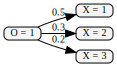

<IPython.core.display.Javascript object>

In [4]:
# Creata a blank probability tree.
pt = PTree()

# Add a root node and the children.
pt.root(
    "O = 1", [pt.child(0.5, "X = 1"), pt.child(0.3, "X = 2"), pt.child(0.2, "X = 3")]
)

# Display it.
display(pt.show())

[('O', '1')]
[('A', '0')]
[('W', '0')]
[('B', '0')]
[('B', '1')]
[('W', '1')]
[('B', '0')]
[('B', '1')]
[('A', '1')]
[('B', '0')]
[('W', '0')]
[('W', '1')]
[('B', '1')]
[('W', '0')]
[('W', '1')]


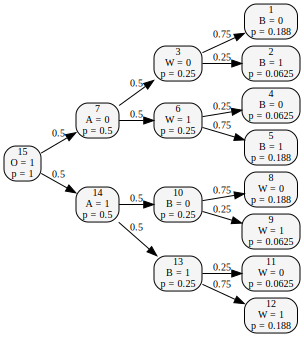

<IPython.core.display.Javascript object>

In [5]:
# create base prob tree
# Create blank tree.
wb = PTree()

# Set the root node and its sub-nodes.
wb.root(
    "O = 1",
    [
        wb.child(
            0.5,
            "A = 0",
            [
                wb.child(
                    0.5, "W = 0", [wb.child(0.75, "B = 0"), wb.child(0.25, "B = 1")]
                ),
                wb.child(
                    0.5, "W = 1", [wb.child(0.25, "B = 0"), wb.child(0.75, "B = 1")]
                ),
            ],
        ),
        wb.child(
            0.5,
            "A = 1",
            [
                wb.child(
                    0.5, "B = 0", [wb.child(0.75, "W = 0"), wb.child(0.25, "W = 1")]
                ),
                wb.child(
                    0.5, "B = 1", [wb.child(0.25, "W = 0"), wb.child(0.75, "W = 1")]
                ),
            ],
        ),
    ],
)

# Display it.
display(wb.show(show_id=True, show_prob=True))

0.5
0.5
0.75
yes: [('B', '0')]
0.25
no: [('B', '1')]
expec sum is: 0.75
[('W', '0'), ('Expec', '0.75')]
0.5
0.25
yes: [('B', '0')]
0.75
no: [('B', '1')]
expec sum is: 0.25
[('W', '1'), ('Expec', '0.25')]
expec sum is: 0.5
[('A', '0'), ('Expec', '0.5')]
0.5
0.5
0.75
no: [('W', '0')]
0.25
no: [('W', '1')]
expec sum is: 0.0
[('B', '0'), ('Expec', '0.0')]
0.5
0.25
no: [('W', '0')]
0.75
no: [('W', '1')]
expec sum is: 0.0
[('B', '1'), ('Expec', '0.0')]
expec sum is: 0.0
[('A', '1'), ('Expec', '0.0')]
expec sum is: 0.25
[('O', '1'), ('Expec', '0.25')]
[('O', '1')]
[('A', '0')]
[('W', '0')]
[('B', '0')]
[('B', '1')]
[('W', '1')]
[('B', '0')]
[('B', '1')]
[('A', '1')]
[('B', '0')]
[('W', '0')]
[('W', '1')]
[('B', '1')]
[('W', '0')]
[('W', '1')]


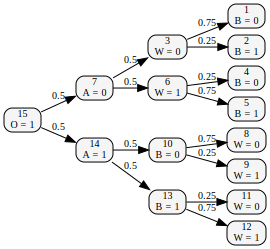

{1: 1, 2: 0, 3: 0.75, 4: 1, 5: 0, 6: 0.25, 7: 0.5, 8: 0, 9: 0, 10: 0.0, 11: 0, 12: 0, 13: 0.0, 14: 0.0, 15: 0.25}


<IPython.core.display.Javascript object>

In [6]:
# create dual expectation prob tree
""" Where the tree chops off children after the event has occured and marks each state with the expectation 
that some target event occurs"""
target = ("B", "0")
expec_dict = wb.expectation_tree(("B", "0"))
display(wb.show(show_id=True))
print(expec_dict)

[('O', '1')]
[('A', '0')]
[('W', '0')]
[('B', '0')]
[('B', '1')]
[('W', '1')]
[('B', '0')]
[('B', '1')]
[('A', '1')]
[('B', '0')]
[('W', '0')]
[('W', '1')]
[('B', '1')]
[('W', '0')]
[('W', '1')]


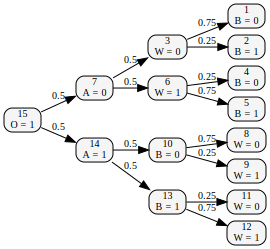

[(7, [15, 14, 10, 8]), (3, [7, 6, 5]), (1, [3, 2]), (4, [6, 5])]


<IPython.core.display.Javascript object>

In [7]:
# mark prevention nodes
""" Now we define the nodes which block events which prevent the target from occuring, defined by a 
tolerance value. As we will see this defination of explanability is actually a relative one."""

tolerance = 0.2
sig_nodes = wb.get_prevention_nodes(tolerance, expec_dict, target)
display(wb.show(show_id=True))
print(sig_nodes)

In [8]:
# Generate explanations for marked nodes
""" Now for each node we show the event trace prevented which blocks the target from occuring"""

for node, prevented_trace in sig_nodes:
    print(f"For node: {node} the prevented trace is: {prevented_trace}")

For node: 7 the prevented trace is: [15, 14, 10, 8]
For node: 3 the prevented trace is: [7, 6, 5]
For node: 1 the prevented trace is: [3, 2]
For node: 4 the prevented trace is: [6, 5]


<IPython.core.display.Javascript object>

In [9]:

def KappaModel( bvars, b = 1,
                      u = 17,
                      u_star = 2,
                      pS = 2,
                      pK = 1, 
                      tmax=6,
                      semantics='trace'):
    
    t=0
    if 'Rule0' not in bvars:
        return init( t )
    while f'Rule{t}' in bvars:
        t += 1
    if t <= tmax:
        return apply_rules( bvars, t, b, u, u_star, pS , pK, semantics )
    else:
        return None   

def init( t):
    return f'Rule{t}=init, bind{t}=0, S{t}=u, K{t}=u'

def apply_rules( bvar, t, b, u, u_star, pS, pK, semantics='trace' ):
    prob_state = []
    prob_state.append( binding( bvar, b, t ) )
    prob_state.append(fast_unbinding(bvar, u, t ) )
    prob_state.append( slow_unbinding( bvar, u_star, t ) )
    prob_state.append(substrate_phosphorylation( bvar, pS, t))
    prob_state.append( kinase_phosphorylation( bvar, pK, t))
    total_prob = sum([prob for prob, state in prob_state])
    if semantics=='trace':
        return [(prob/total_prob, state) 
                for prob, state in prob_state
                if prob > 0]
    else:
        return [(prob/total_prob, state) 
                for prob, state in prob_state]


def binding( bvar, b, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '0':
        return b, f'Rule{t}=b, bind{t}=1, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=b, bind{t}={bind}, S{t}={S}, K{t}={K}'

def fast_unbinding( bvar, u, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'u':
        return u, f'Rule{t}=u, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def slow_unbinding( bvar, u_star, t):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and K == 'p':
        return u_star, f'Rule{t}=u_star, bind{t}=0, S{t}={S}, K{t}={K}'
    else:
        return 0, f'Rule{t}=u_star, bind{t}={bind}, S{t}={S}, K{t}={K}'

def substrate_phosphorylation( bvar, pS, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if bind == '1' and S == 'u':
        return pS, f'Rule{t}=pS, bind{t}={bind}, S{t}=p, K{t}={K}'
    else:
        return 0, f'Rule{t}=pS, bind{t}={bind}, S{t}={S}, K{t}={K}'
    
def kinase_phosphorylation( bvar, pK, t ):
    bind, S, K = bvar[f'bind{t-1}'], bvar[f'S{t-1}'], bvar[f'K{t-1}']
    if K == 'u':
        return pK, f'Rule{t}=pK, bind{t}={bind}, S{t}={S}, K{t}=p'
    else:
        return 0, f'Rule{t}=pK, bind{t}={bind}, S{t}={S}, K{t}={K}'


<IPython.core.display.Javascript object>

[('Rule0', 'init'), ('bind0', '0'), ('S0', 'u'), ('K0', 'u')]
[('Rule1', 'b'), ('bind1', '1'), ('S1', 'u'), ('K1', 'u')]
[('Rule2', 'u'), ('bind2', '0'), ('S2', 'u'), ('K2', 'u')]
[('Rule3', 'b'), ('bind3', '1'), ('S3', 'u'), ('K3', 'u')]
[('Rule4', 'u'), ('bind4', '0'), ('S4', 'u'), ('K4', 'u')]
[('Rule5', 'b'), ('bind5', '1'), ('S5', 'u'), ('K5', 'u')]
[('Rule6', 'u'), ('bind6', '0'), ('S6', 'u'), ('K6', 'u')]
[('Rule6', 'pS'), ('bind6', '1'), ('S6', 'p'), ('K6', 'u')]
[('Rule6', 'pK'), ('bind6', '1'), ('S6', 'u'), ('K6', 'p')]
[('Rule5', 'pK'), ('bind5', '0'), ('S5', 'u'), ('K5', 'p')]
[('Rule6', 'b'), ('bind6', '1'), ('S6', 'u'), ('K6', 'p')]
[('Rule4', 'pS'), ('bind4', '1'), ('S4', 'p'), ('K4', 'u')]
[('Rule5', 'u'), ('bind5', '0'), ('S5', 'p'), ('K5', 'u')]
[('Rule6', 'b'), ('bind6', '1'), ('S6', 'p'), ('K6', 'u')]
[('Rule6', 'pK'), ('bind6', '0'), ('S6', 'p'), ('K6', 'p')]
[('Rule5', 'pK'), ('bind5', '1'), ('S5', 'p'), ('K5', 'p')]
[('Rule6', 'u_star'), ('bind6', '0'), ('S6', 'p

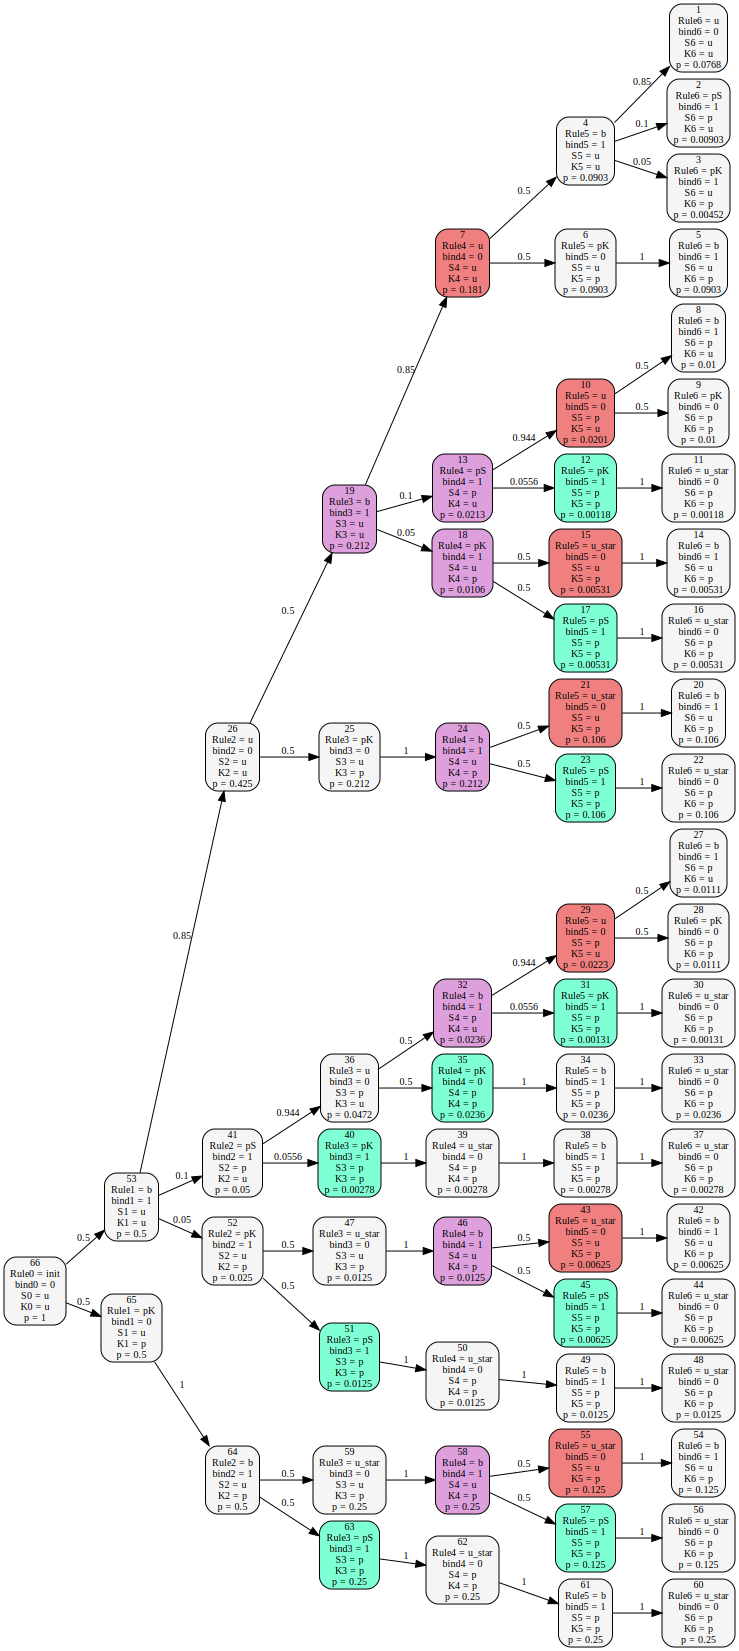

<IPython.core.display.Javascript object>

In [10]:
kappa = PTree.fromFunc(KappaModel, init(0))
display(
    kappa.show(
        show_prob=True,
        cut=kappa.prop("Rule6=u_star"),
        crit=kappa.critical(kappa.prop("Rule6=u_star")),
        show_id=True,
    )
)

In [13]:
target = ("Rule6", "u_star")
expec_dict = kappa.expectation_tree(target)
# display(wb.show(show_id=True))
# print(expec_dict)
tolerance = 0.2
sig_nodes = kappa.get_prevention_nodes(tolerance, expec_dict, target)
# display(kappa.show(show_id=True))
print(sig_nodes)
for node, prevented_trace in sig_nodes:
    print(f"For node: {node} the prevented trace is: {prevented_trace}")

0.5
0.85
0.5
0.85
0.5
0.85
no: [('Rule6', 'u'), ('bind6', '0'), ('S6', 'u'), ('K6', 'u')]
0.1
no: [('Rule6', 'pS'), ('bind6', '1'), ('S6', 'p'), ('K6', 'u')]
0.05
no: [('Rule6', 'pK'), ('bind6', '1'), ('S6', 'u'), ('K6', 'p')]
expec sum is: 0.0
[('Rule5', 'b'), ('bind5', '1'), ('S5', 'u'), ('K5', 'u'), ('Expec', '0.0')]
0.5
1.0
no: [('Rule6', 'b'), ('bind6', '1'), ('S6', 'u'), ('K6', 'p')]
expec sum is: 0.0
[('Rule5', 'pK'), ('bind5', '0'), ('S5', 'u'), ('K5', 'p'), ('Expec', '0.0')]
expec sum is: 0.0
[('Rule4', 'u'), ('bind4', '0'), ('S4', 'u'), ('K4', 'u'), ('Expec', '0.0')]
0.1
0.9444444444444444
0.5
no: [('Rule6', 'b'), ('bind6', '1'), ('S6', 'p'), ('K6', 'u')]
0.5
no: [('Rule6', 'pK'), ('bind6', '0'), ('S6', 'p'), ('K6', 'p')]
expec sum is: 0.0
[('Rule5', 'u'), ('bind5', '0'), ('S5', 'p'), ('K5', 'u'), ('Expec', '0.0')]
0.05555555555555555
1.0
yes: [('Rule6', 'u_star'), ('bind6', '0'), ('S6', 'p'), ('K6', 'p')]
expec sum is: 1.0
[('Rule5', 'pK'), ('bind5', '1'), ('S5', 'p'), ('K5'

<IPython.core.display.Javascript object>